<a href="https://colab.research.google.com/github/HMUNACHI/number_classification_using_pytorch/blob/master/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing the necessary modules
import torch
import numpy as np
from torchvision import datasets
from torch import optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# defining required variables
num_workers = 0
batch_size = 20
valid_size = 0.2
transform = transforms.ToTensor()

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
# preparing the data
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
    )

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
    )

train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size = batch_size,
                                          sampler = train_sampler,
                                          num_workers = num_workers
                                          )

valid_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size = batch_size,
                                          sampler = valid_sampler,
                                          num_workers = num_workers
                                          )

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size = batch_size,
                                          num_workers = num_workers
                                          )

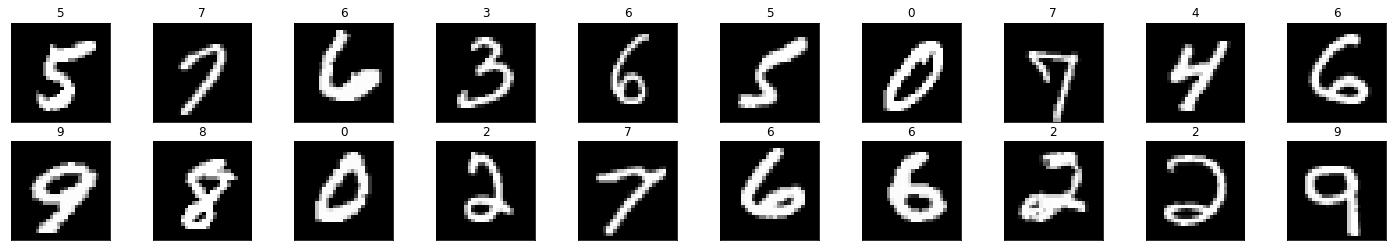

In [51]:
#visualising the data
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap = 'gray' )
    ax.set_title(str(labels[idx].item()))

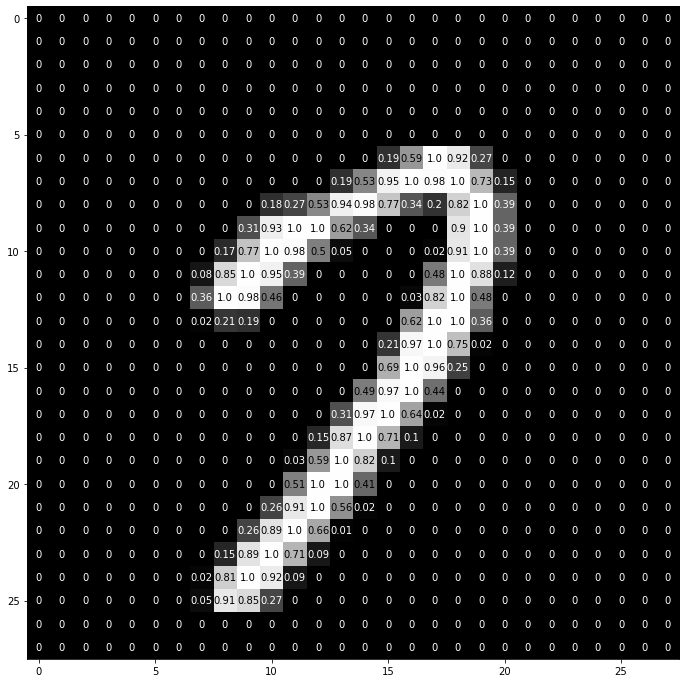

In [52]:
# view detailed image
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [0]:
# constructing the neural network architecture

class network (nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward (self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(x, dim=1)
        return x

In [0]:
# defining the model
model = network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 10
valid_loss_min = np.Inf #set initial mean to infinity

In [70]:
# training the network
for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.287844 	Validation Loss: 0.554481
Epoch: 2 	Training Loss: 1.054792 	Validation Loss: 0.172246
Validation loss decreased (0.262489 --> 0.172246).  Saving model ...
Epoch: 3 	Training Loss: 0.960148 	Validation Loss: 0.177942
Epoch: 4 	Training Loss: 0.948279 	Validation Loss: 0.195386
Epoch: 5 	Training Loss: 0.959781 	Validation Loss: 0.172594
Epoch: 6 	Training Loss: 0.955301 	Validation Loss: 0.166199
Validation loss decreased (0.172246 --> 0.166199).  Saving model ...
Epoch: 7 	Training Loss: 0.953552 	Validation Loss: 0.169442
Epoch: 8 	Training Loss: 0.941319 	Validation Loss: 0.181077
Epoch: 9 	Training Loss: 0.940538 	Validation Loss: 0.174285
Epoch: 10 	Training Loss: 0.928547 	Validation Loss: 0.172802


In [71]:
# loading the model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [72]:
# testing the model
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.152777

Test Accuracy of     0: 98% (965/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 97% (1010/1032)
Test Accuracy of     3: 97% (989/1010)
Test Accuracy of     4: 97% (957/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 98% (1008/1028)
Test Accuracy of     8: 96% (938/974)
Test Accuracy of     9: 96% (970/1009)

Test Accuracy (Overall): 97% (9755/10000)


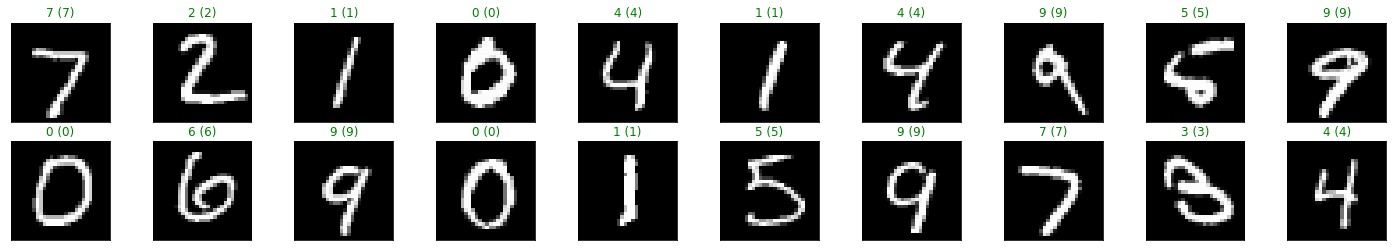

In [73]:
# visualising test
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))